In [2]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from triplet_utils import *
from utils import *
from torch.utils.data import random_split
from triplet_utils import train_and_evaluate_triplet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(42)

In [3]:
CHECKPOINTS_DIR = "checkpoints"

In [4]:
def custom_collate(batch):
    # Unpack the batch
    anchors, positives, negatives, labels = zip(*batch)

    # Stack tensors to create batches
    anchors = torch.stack(anchors)
    positives = torch.stack(positives)
    negatives = torch.stack(negatives)

    # Convert labels to a tensor
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    return anchors, positives, negatives, labels

# TripletModel definition
class TripletModel(nn.Module):
    def __init__(self):
        super(TripletModel, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 128)  # Adjust output size for embedding

    def forward(self, x):
        # Get the embedding directly from the base model
        return self.base_model(x)  # Call the model with input x

class TripletClassifier(nn.Module):
    def __init__(self, triplet_head, output_size=1):
        super(TripletClassifier, self).__init__()
        self.triplet_head = triplet_head
        self.classifier = nn.Linear(self.triplet_head.base_model.fc.out_features, output_size)  # Binary classification (logits)

    def forward(self, x):
        embedding = self.triplet_head(x)  # Output of base model
        class_output = self.classifier(embedding)  # Output for classification
        return embedding, class_output
    
    
# Load data
data_dir = '../../data/BiteCount/salient_poses/'

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to square input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = TripletDataset(data_dir, val_transforms)
val_loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

# Initialize TripletModel
triplet_model = TripletModel()
model = TripletClassifier(triplet_model)
model = model.to(device)
model.load_state_dict(torch.load(checkpoint))

/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadat/miniconda3/envs/cowbytes/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'checkpoint' is not defined

/tmp/ipykernel_2050088/2756231084.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint))


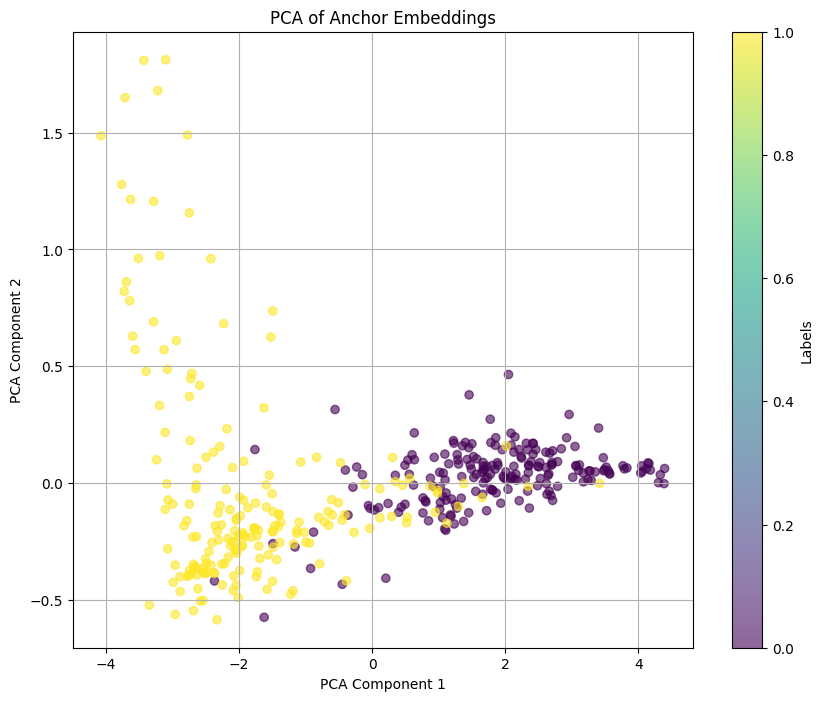

In [16]:
import torch
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

checkpoint = os.path.join(CHECKPOINTS_DIR, 'modified_tripet_margin0.1_momentum=0.5 lr=0.1.pth')
model.load_state_dict(torch.load(checkpoint))

# Set the model to evaluation mode
model.eval()

# Lists to hold the embeddings and labels
embeddings = []
labels_list = []

# Iterate through the validation DataLoader
with torch.no_grad():
    for anchors, positives, negatives, labels in val_loader:
        # Move data to device
        anchors = anchors.to(device)
        
        # Get the embeddings for anchors
        embedding = model.triplet_head(anchors)
        
        # Append to the lists
        embeddings.append(embedding.cpu().numpy())  # Convert to numpy array
        labels_list.append(labels.numpy())  # Convert to numpy array

# Concatenate all embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

# Perform PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Plot the PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels_list, cmap='viridis', alpha=0.6)

# Create a color bar
plt.colorbar(scatter, label='Labels')
plt.title('PCA of Anchor Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()


/tmp/ipykernel_2050088/3425409204.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint))


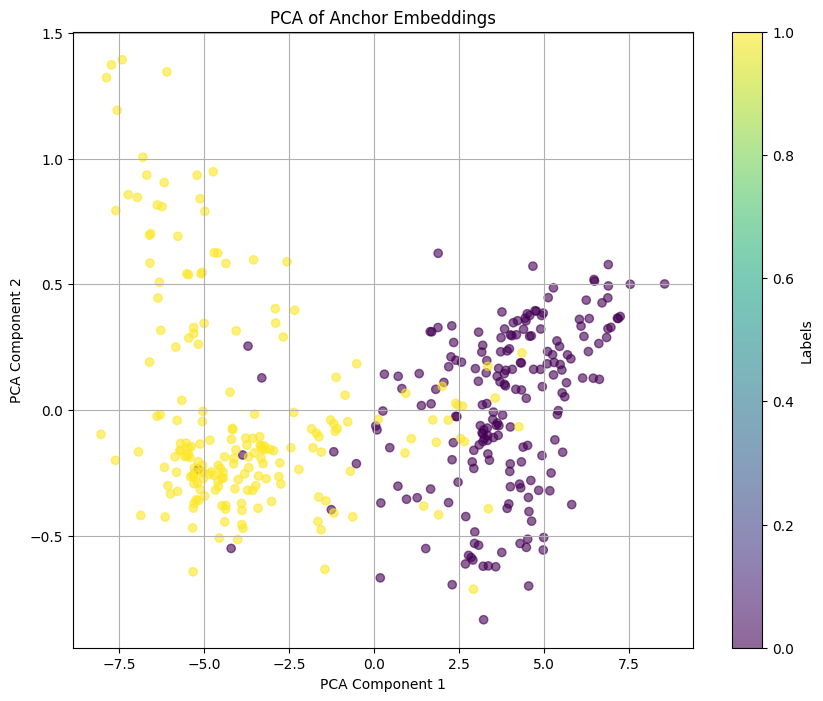

In [17]:
import torch
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

checkpoint = os.path.join(CHECKPOINTS_DIR, 'modified_tripet_margin2_momentum=0.8_lr=0.1.pth')
model.load_state_dict(torch.load(checkpoint))

# Set the model to evaluation mode
model.eval()

# Lists to hold the embeddings and labels
embeddings = []
labels_list = []

# Iterate through the validation DataLoader
with torch.no_grad():
    for anchors, positives, negatives, labels in val_loader:
        # Move data to device
        anchors = anchors.to(device)
        
        # Get the embeddings for anchors
        embedding = model.triplet_head(anchors)
        
        # Append to the lists
        embeddings.append(embedding.cpu().numpy())  # Convert to numpy array
        labels_list.append(labels.numpy())  # Convert to numpy array

# Concatenate all embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

# Perform PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Plot the PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels_list, cmap='viridis', alpha=0.6)

# Create a color bar
plt.colorbar(scatter, label='Labels')
plt.title('PCA of Anchor Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()


/tmp/ipykernel_2398239/1160531751.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint))


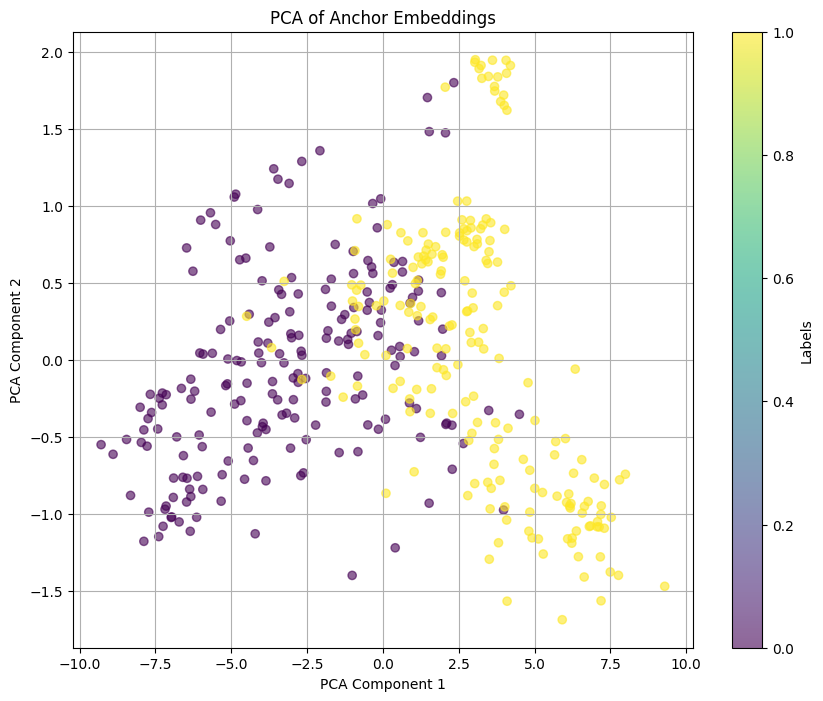

In [4]:
import torch
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

checkpoint = os.path.join(CHECKPOINTS_DIR, 'modified_tripet_margin_2_alpha1.pth')
model.load_state_dict(torch.load(checkpoint))

# Set the model to evaluation mode
model.eval()

# Lists to hold the embeddings and labels
embeddings = []
labels_list = []

# Iterate through the validation DataLoader
with torch.no_grad():
    for anchors, positives, negatives, labels in val_loader:
        # Move data to device
        anchors = anchors.to(device)
        
        # Get the embeddings for anchors
        embedding = model.triplet_head(anchors)
        
        # Append to the lists
        embeddings.append(embedding.cpu().numpy())  # Convert to numpy array
        labels_list.append(labels.numpy())  # Convert to numpy array

# Concatenate all embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

# Perform PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Plot the PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels_list, cmap='viridis', alpha=0.6)

# Create a color bar
plt.colorbar(scatter, label='Labels')
plt.title('PCA of Anchor Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()


/tmp/ipykernel_2643818/3990973060.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint))


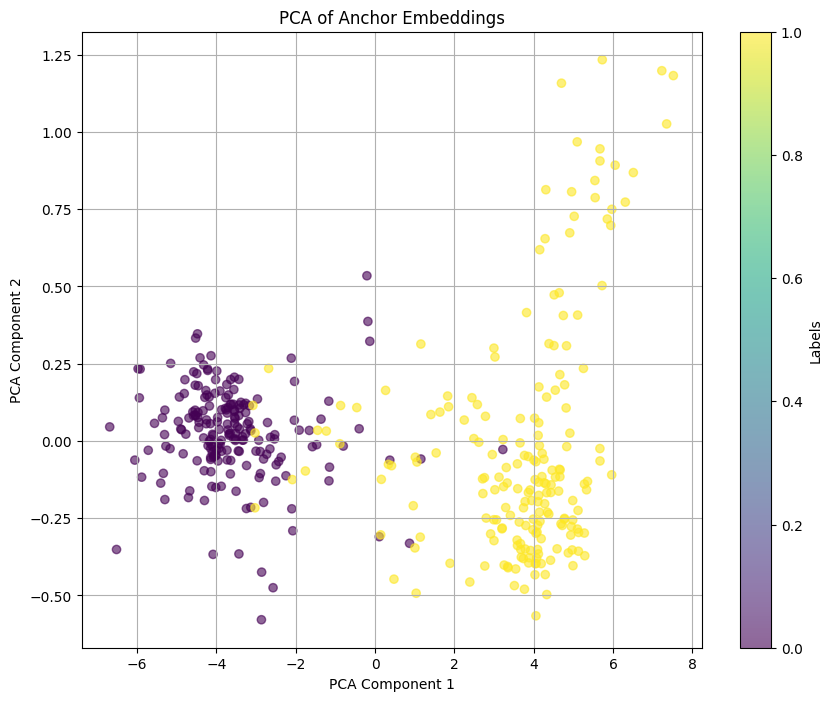

In [5]:
import torch
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

checkpoint = os.path.join(CHECKPOINTS_DIR, 'modified_tripet_margin_1_positive_v3.pth')
model.load_state_dict(torch.load(checkpoint))

# Set the model to evaluation mode
model.eval()

# Lists to hold the embeddings and labels
embeddings = []
labels_list = []

# Iterate through the validation DataLoader
with torch.no_grad():
    for anchors, positives, negatives, labels in val_loader:
        # Move data to device
        anchors = anchors.to(device)
        
        # Get the embeddings for anchors
        embedding = model.triplet_head(anchors)
        
        # Append to the lists
        embeddings.append(embedding.cpu().numpy())  # Convert to numpy array
        labels_list.append(labels.numpy())  # Convert to numpy array

# Concatenate all embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

# Perform PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Plot the PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels_list, cmap='viridis', alpha=0.6)

# Create a color bar
plt.colorbar(scatter, label='Labels')
plt.title('PCA of Anchor Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()
